<a href="https://colab.research.google.com/github/Jushef/Stock-Market-Analysis/blob/main/financial_analysis_copia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis financiero con el paquete `stock_analysis`


| Propósito | Clase(s) | Módulo |
| --- | --- | --- |
| Recoger los datos de varias fuentes | `StockReader` | `stock_reader.py` |
| Visualización de los datos | `Visualizer`, `StockVisualizer`, `AssetGroupVisualizer` | `stock_visualizer.py` |
| Cálculo de métricas financieras | `StockAnalyzer`, `AssetGroupAnalyzer` | `stock_analyzer.py` |
| Modelización de los datos | `StockModeler` | `stock_modeler.py` |

## Recogida de datos
La clase `StockReader` del paquete `stock_analysis` facilita la recogida de datos financieros, como los precios de la bolsa o del bitcoin. Simplemente tenemos que crear una instancia especificando el rango de fechas. Luego, podemos tomar los datos:

In [ ]:
import stock_analysis

reader = stock_analysis.StockReader('2021-04-01', '2022-04-10')

# obtener datos de faang
fb, aapl, amzn, nflx, goog = (
    reader.get_ticker_data(ticker)
    for ticker in ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG']
)

# gy datos del S&P 500
sp = reader.get_index_data('S&P 500')

# obtener datos de bitcoin en USD
bitcoin = reader.get_bitcoin_data('USD')

## EDA
Podemos agrupar nuestros activos en marcos de datos para realizar EDA:

In [ ]:
from stock_analysis.utils import group_stocks, describe_group

faang = group_stocks(
    {
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog
    }
)

faang_sp = group_stocks(
    {
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog,
        'S&P 500': sp
    }
)

all_assets = group_stocks(
    {
        'Bitcoin': bitcoin,
        'S&P 500': sp,
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog
    }
)

Esto hace que sea fácil describirlos todos a la vez:

In [ ]:
describe_group(all_assets).loc['close',]

name,Amazon,Apple,Bitcoin,Facebook,Google,Netflix,S&P 500
count,259.000000,259.000000,375.000000,259.000000,259.000000,259.000000,259.000000
mean,3321.267381,151.225830,46391.970708,314.146024,2690.663712,526.477914,4420.723391
std,196.203964,16.413119,8990.260502,50.791389,209.473235,92.418264,184.329433
min,2720.290039,122.769997,29807.347656,186.630005,2137.750000,331.010010,4019.870117
25%,3227.500000,139.550003,39205.355469,306.395004,2539.944946,490.664993,4260.985107
50%,3335.550049,148.990005,45538.675781,329.820007,2736.030029,530.309998,4422.299805
75%,3446.655029,165.209999,53562.437500,343.784988,2854.310059,598.354980,4546.199951
max,3731.409912,182.009995,67566.828125,382.179993,3014.179932,691.690002,4796.560059


### Visualizaciones
La clase `StockVisualizer` facilita la creación de diversas visualizaciones para el análisis financiero. Simplemente pasamos el dataframe del activo que queremos visualizar:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

netflix_viz = stock_analysis.StockVisualizer(nflx)

Podemos utilizar la media móvil para suavizar la tendencia de la acción. Obsérvese que, en la región sombreada, la media móvil de 90 días actúa como un piso para el precio de las acciones:

[Text(0.5, 1.0, 'Precio de cierre de Netflix'), Text(0, 0.5, 'precio ($)')]

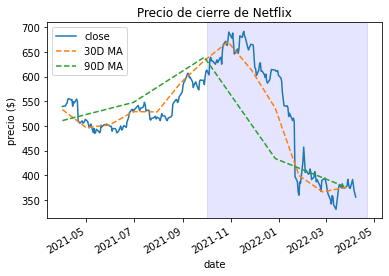

In [ ]:
ax = netflix_viz.moving_average('close', ['30D', '90D'])
netflix_viz.shade_region(
    ax, x=('2021-10-01', '2022-04-22'), color='blue', alpha=0.1
)
ax.set(title='Precio de cierre de Netflix', ylabel='precio ($)')

La media móvil puede utilizarse para determinar los niveles de soporte y resistencia. El soporte ejerce una presión al alza sobre el precio de las acciones (los precios más bajos hacen que la gente compre) y la resistencia ejerce una fuerza a la baja sobre el precio de las acciones (los precios altos hacen que la gente venda):

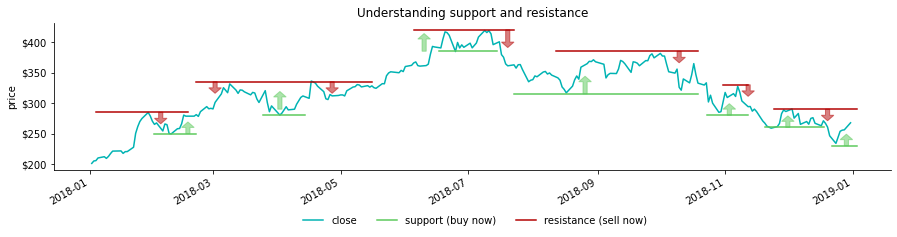

In [ ]:
from visual_aids import finance_viz
_ = finance_viz.support_and_resistance()

A veces el suavizado exponencial tiene más sentido porque podemos dar más importancia a los valores más recientes:

[Text(0.5, 1.0, 'Precio de cierre de Netflix'), Text(0, 0.5, 'precio ($)')]

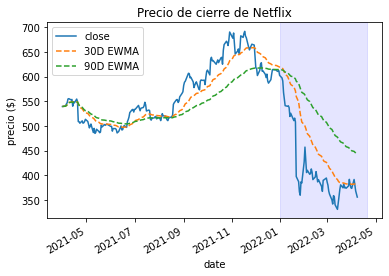

In [ ]:
ax = netflix_viz.exp_smoothing('close', [30, 90])
netflix_viz.shade_region(
    ax, x=('2022-01-01', '2022-04-20'), color='blue', alpha=0.1
)
ax.set(title='Precio de cierre de Netflix', ylabel='precio ($)')

---

**SECCIÓN**: Visualización interactiva de medias móviles

---

Ahora utilizaremos los widgets para crear un gráfico interactivo para ver lo que hacen las diferentes ventanas a la media móvil y a la media móvil suavizada exponencialmente. El uso del widget backend requiere `ipympl`, que ya instalamos en el capítulo 1. Sin embargo, dependiendo de tu configuración de Jupyter y de tu máquina, puede que también necesites instalar `node.js` y ejecutar algunos comandos desde la línea de comandos. Intenta ejecutar las celdas de abajo, y si no funciona sigue las instrucciones de instalación [aquí](https://github.com/matplotlib/jupyter-matplotlib). Asegúrate de reiniciar el kernel cuando estés instalado.

Primero, ejecutamos esta magia para habilitar el back-end de widgets:

In [ ]:
%matplotlib widget

A continuación, ejecutamos el código para generar la visualización interactiva. Para ello se utiliza la función `interact()` de `ipywidgets`:

In [ ]:
%matplotlib widget
from ipywidgets import interact

def moving_averages(viz):
    def plot_viz(period=20, exponentially_smoothed=False):
        if exponentially_smoothed:
            ax = netflix_viz.exp_smoothing('close', period)
        else:
            ax = netflix_viz.moving_average('close', str(period) + 'D')
        
        ax.set(title='Precio de cierre de Netflix', ylabel='precio ($)')
    
    return plot_viz
interact(moving_averages(netflix_viz), period=(5, 200, 5), exponentially_smoothed=False);

interactive(children=(IntSlider(value=20, description='period', max=200, min=5, step=5), Checkbox(value=False,…

*Se puede encontrar más información sobre la función `interact()` [aquí](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html).*

---

Cuando termine con la visualización interactiva, asegúrese de volver a los gráficos `inline` para el resto del cuaderno:

In [ ]:
%matplotlib inline

---

**FINALIZAR SECCIÓN**

---

Veamos el efecto de las operaciones fuera de horario:

array([<AxesSubplot:title={'center':"After-hours trading\n(Open Price - Prior Day's Close)"}, xlabel='date', ylabel='price'>,
       <AxesSubplot:title={'center':'After-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
      dtype=object)

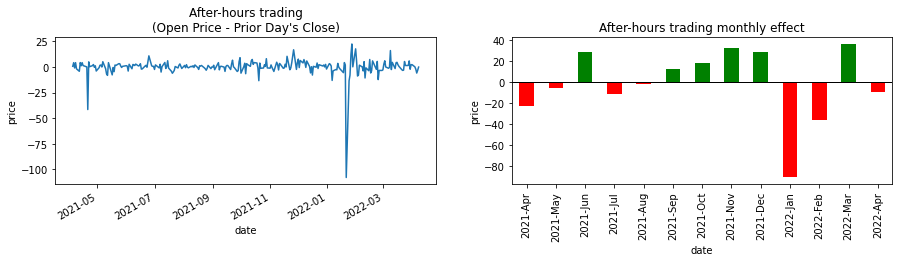

In [ ]:
netflix_viz.after_hours_trades()

Podemos utilizar un **trazado de velas** para estudiar los datos de OHLC. Puede encontrar más información sobre su lectura e interpretación [aquí](https://www.investopedia.com/trading/candlestick-charting-what-is-it/).

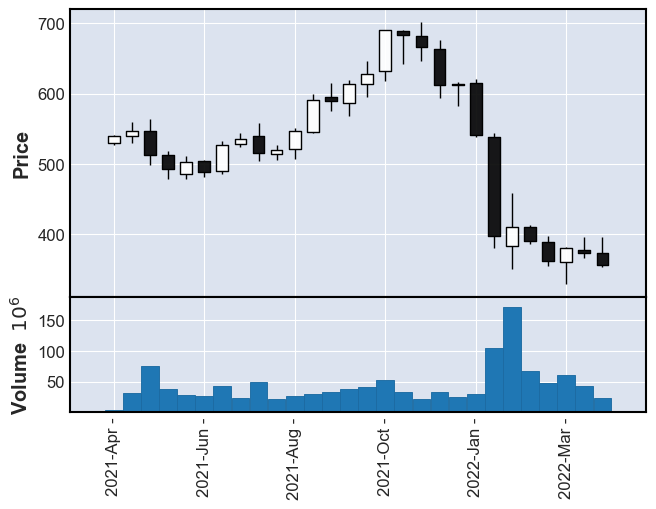

In [ ]:
netflix_viz.candlestick(resample='2W', volume=True, xrotation=90, datetime_format='%Y-%b -')

El paquete `mplfinance` utiliza sus propias hojas de estilo para el trazado, así que vamos a restaurar los valores por defecto:

In [ ]:
import matplotlib as mpl
mpl.rcdefaults()
%matplotlib inline

Podemos utilizar un gráfico conjunto para ver cómo se compara Netflix con el S&P 500:

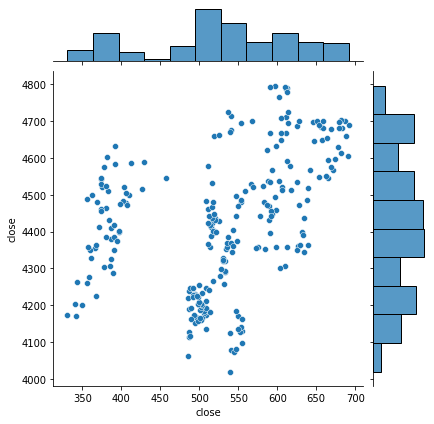

In [ ]:
netflix_viz.jointplot(sp, 'close')

También podemos utilizar la función `correlation_heatmap()` para ver la correlación del cambio porcentual diario. Aquí, comparamos con Amazon:

<AxesSubplot:>

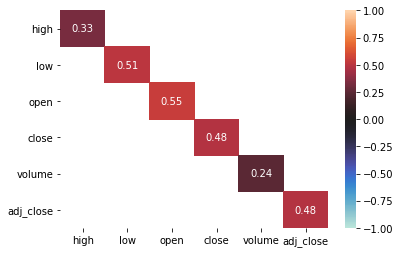

In [ ]:
netflix_viz.correlation_heatmap(amzn)

Podemos utilizar el método `fill_between_other()` para comparar el precio de las acciones de Netflix a lo largo del tiempo con otro activo. En este caso, nos fijamos en Tesla:

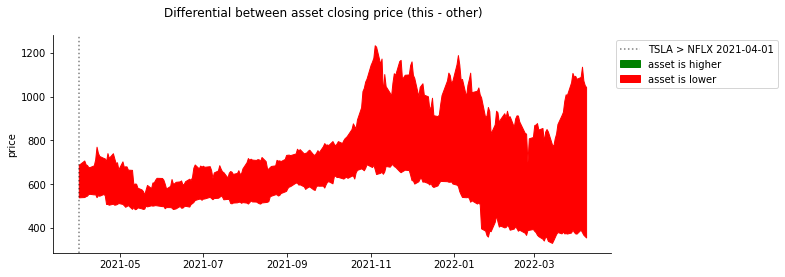

In [ ]:
tsla = reader.get_ticker_data('TSLA')
change_date = (tsla.close > nflx.close).idxmax()
ax = netflix_viz.fill_between_other(tsla)
netflix_viz.add_reference_line(
    ax, 
    x=change_date, 
    color='k', 
    linestyle=':', 
    label=f'TSLA > NFLX {change_date:%Y-%m-%d}',
    alpha=0.5
)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

Si queremos visualizar grupos de activos, utilizamos la clase `AssetGroupVisualizer`. Veamos las correlaciones entre los activos utilizando el porcentaje de cambio:

<AxesSubplot:xlabel='name', ylabel='name'>

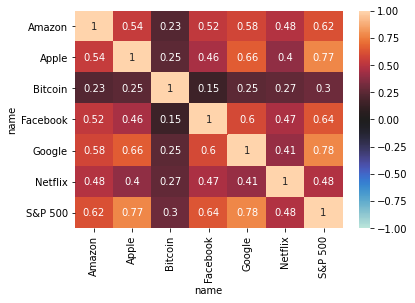

In [ ]:
all_assets_viz = stock_analysis.AssetGroupVisualizer(all_assets)
all_assets_viz.heatmap()

El Bitcoin se encuentra en una escala mucho mayor, por lo que tenemos que utilizar subtramas para compararlo con el mercado de valores:

<AxesSubplot:xlabel='date'>

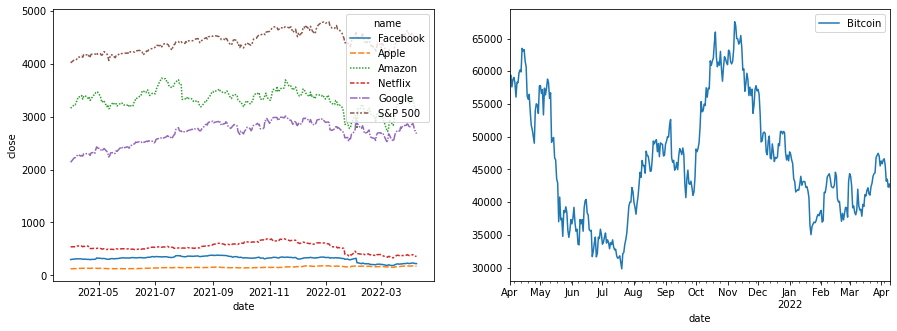

In [ ]:
faang_sp_viz = stock_analysis.AssetGroupVisualizer(faang_sp)
bitcoin_viz = stock_analysis.StockVisualizer(bitcoin)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
faang_sp_viz.evolution_over_time('close', ax=axes[0], style=faang_sp_viz.group_by)
bitcoin_viz.evolution_over_time('close', ax=axes[1], label='Bitcoin')

### Gráficos adicionales (no en el texto)
Podemos ver el efecto que tuvo la negociación fuera de horario en cada una de las acciones de las FAANG:

array([[<AxesSubplot:title={'center':"Amazon Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Amazon after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Apple Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Apple after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Facebook Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Facebook after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Google Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Google after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Netflix Open Price - Prior Day's Close"}, xlabel='da

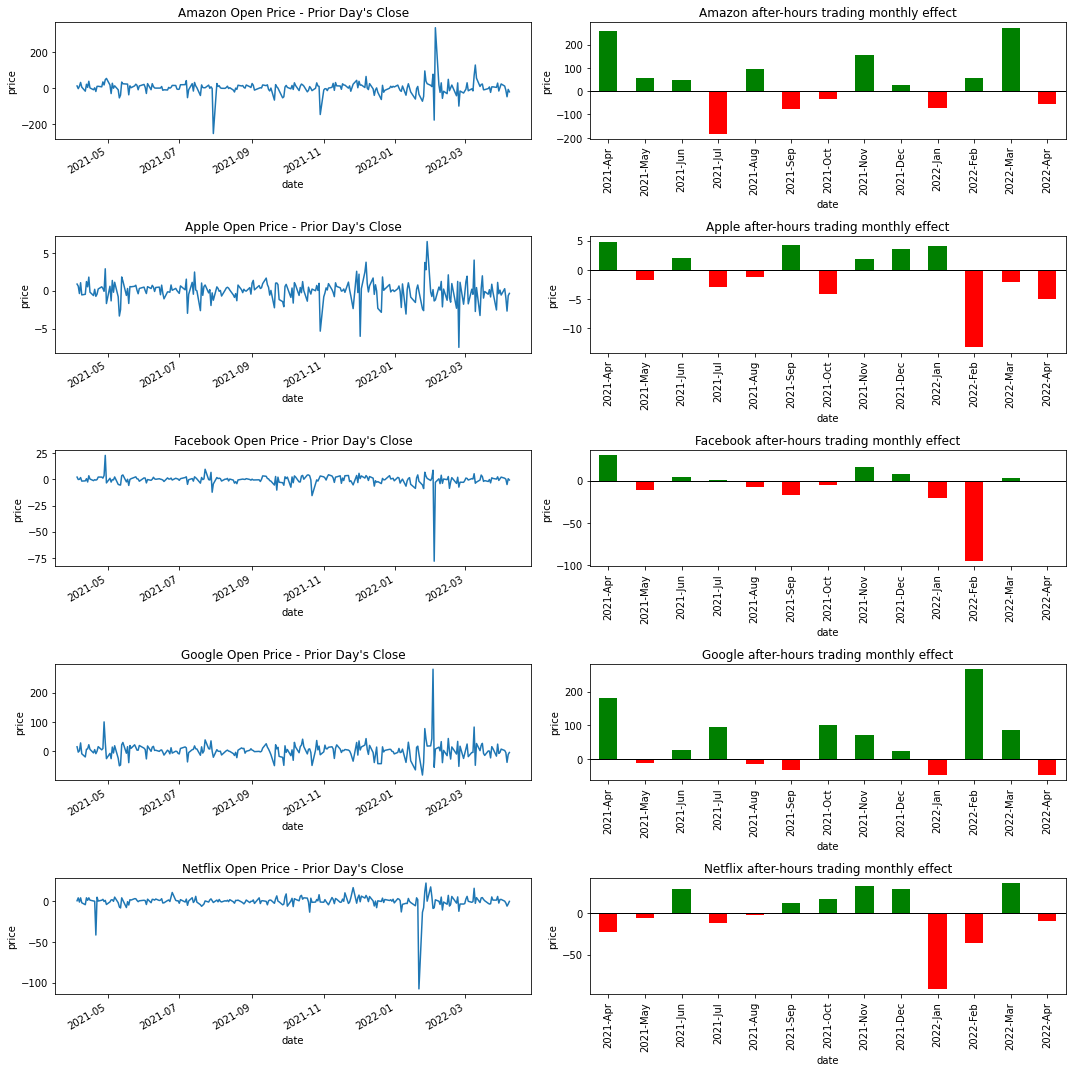

In [ ]:
faang_viz = stock_analysis.AssetGroupVisualizer(faang)
faang_viz.after_hours_trades()

También podemos ver cómo son las medias móviles suavizadas exponencialmente para todos los valores FAANG:

<AxesSubplot:xlabel='date'>

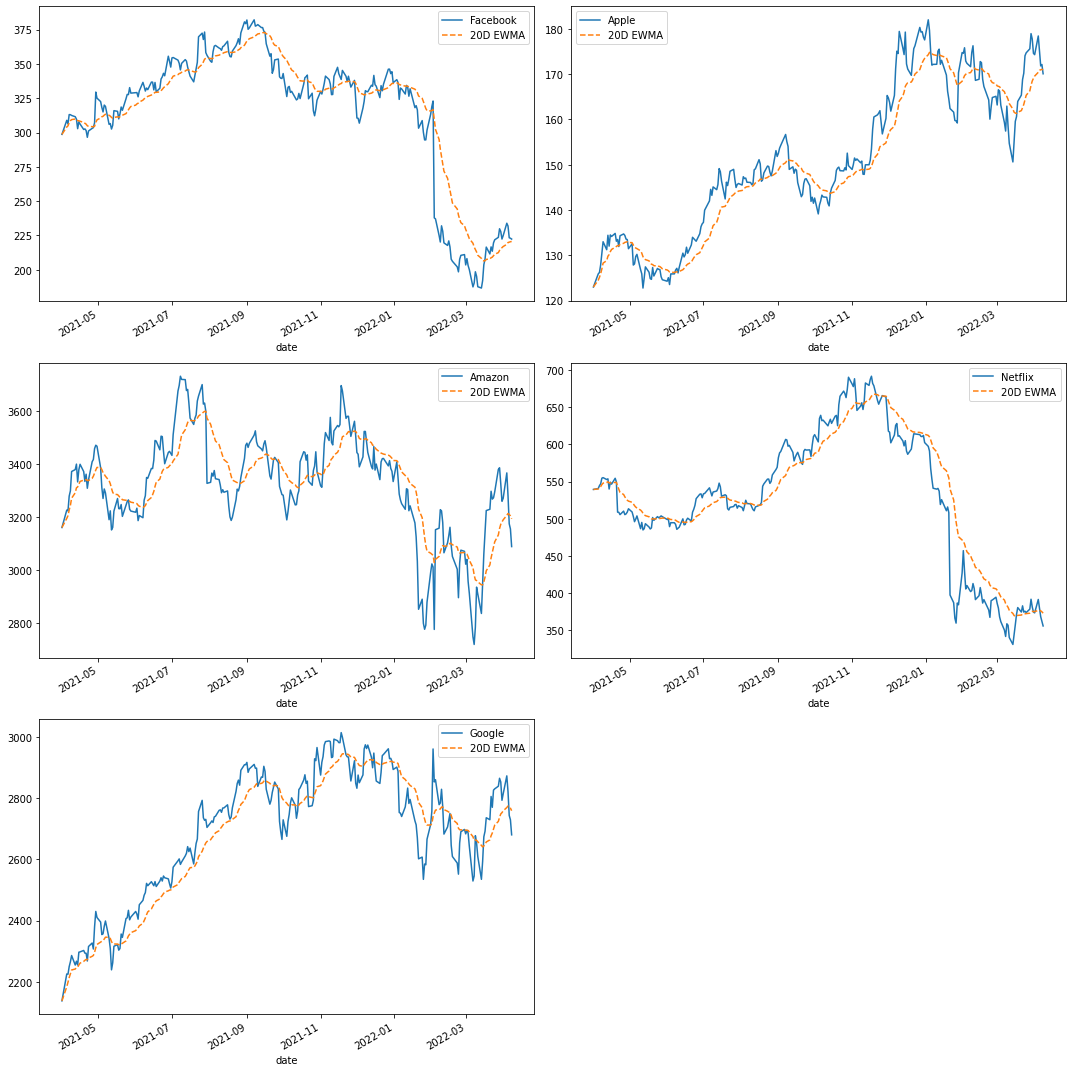

In [ ]:
faang_viz.exp_smoothing('close', 20)

Con ventanas cortas, ambos métodos de suavizado tienen un rendimiento similar:

<AxesSubplot:xlabel='date'>

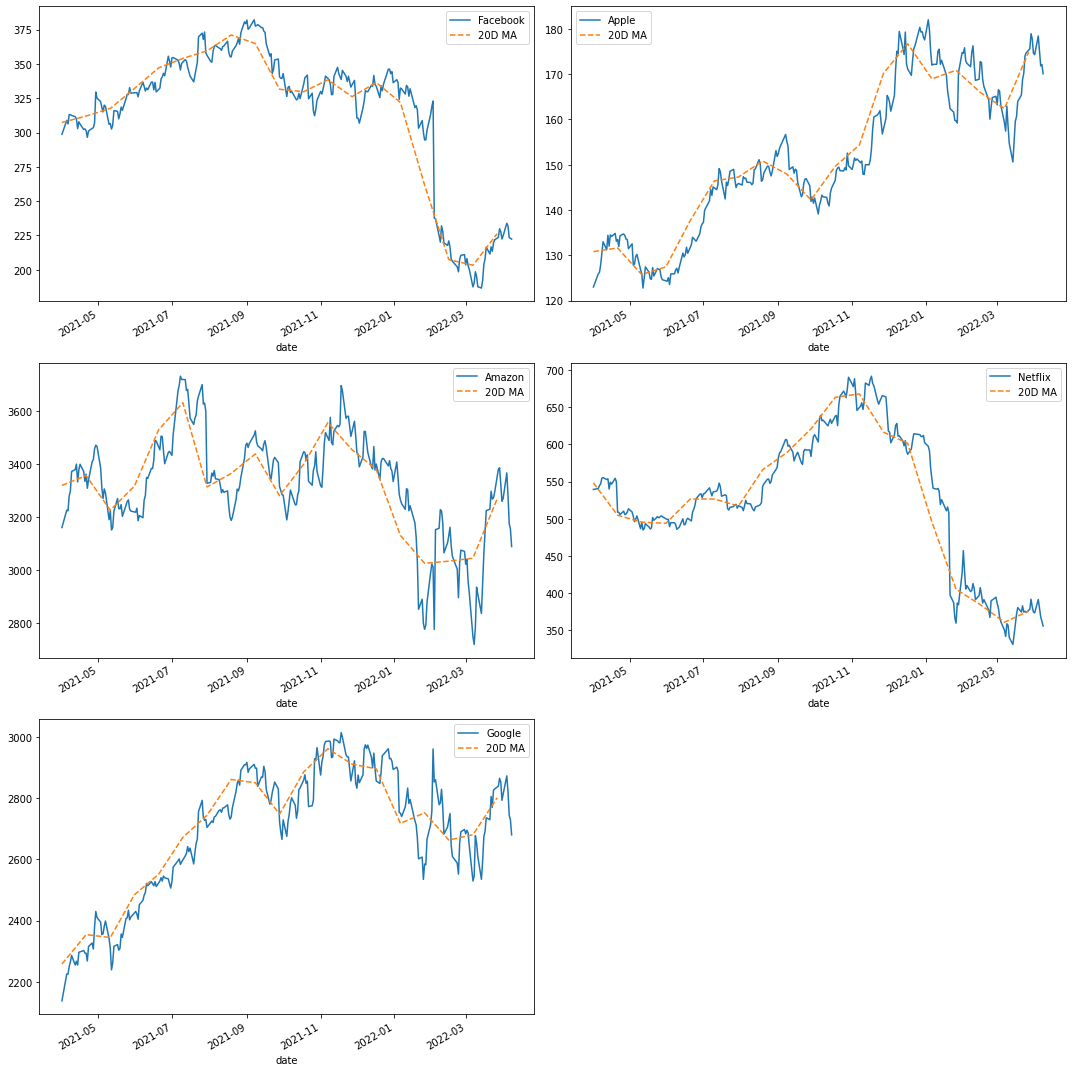

In [ ]:
faang_viz.moving_average('close', '20D')

Las distribuciones del precio de cierre entre los valores de las FAANG son bastante diferentes:

array([<AxesSubplot:title={'center':'Amazon - close'}, xlabel='close', ylabel='Count'>,
       <AxesSubplot:title={'center':'Apple - close'}, xlabel='close', ylabel='Count'>,
       <AxesSubplot:title={'center':'Facebook - close'}, xlabel='close', ylabel='Count'>,
       <AxesSubplot:title={'center':'Google - close'}, xlabel='close', ylabel='Count'>,
       <AxesSubplot:title={'center':'Netflix - close'}, xlabel='close', ylabel='Count'>,
       <AxesSubplot:>], dtype=object)

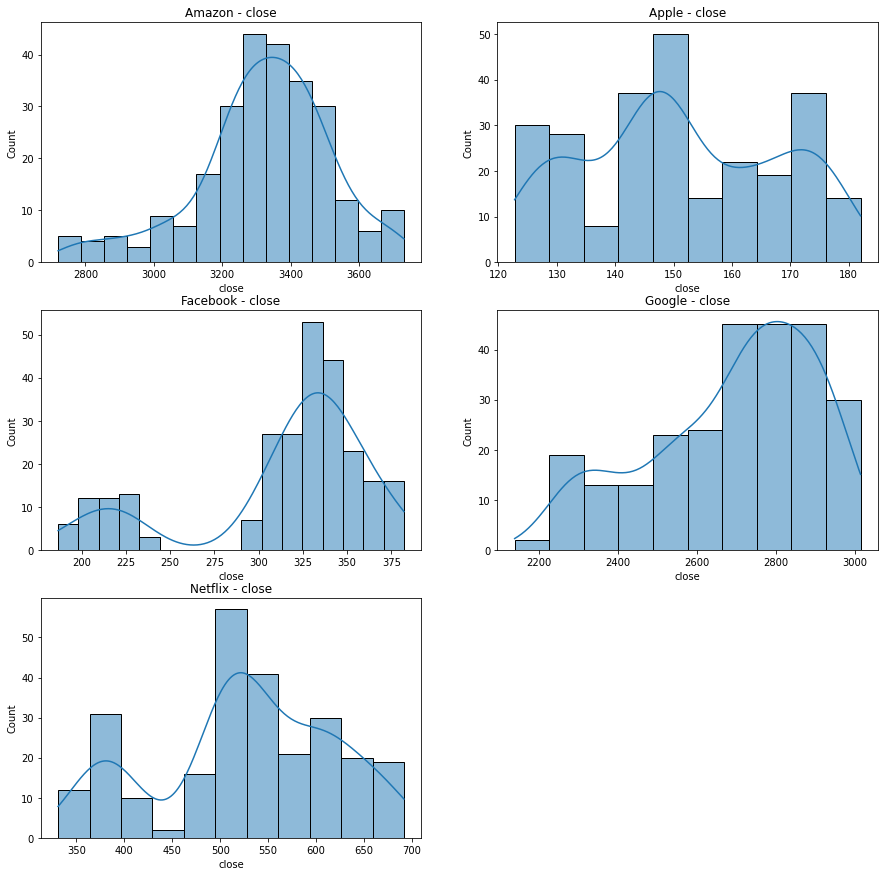

In [ ]:
faang_viz.histogram('close')

Viendo los gráficos de caja podemos ver fácilmente que Google y Amazon están en una escala mucho mayor:

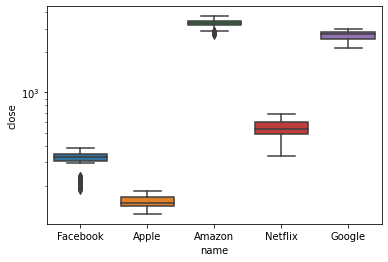

In [ ]:
faang_viz.boxplot('close')
plt.yscale('log')

Las correlaciones entre los valores son débiles:

<AxesSubplot:xlabel='name', ylabel='name'>

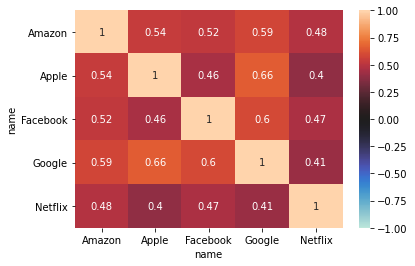

In [ ]:
faang_viz.heatmap()

También podemos ver esta información en forma de gráficos de dispersión:

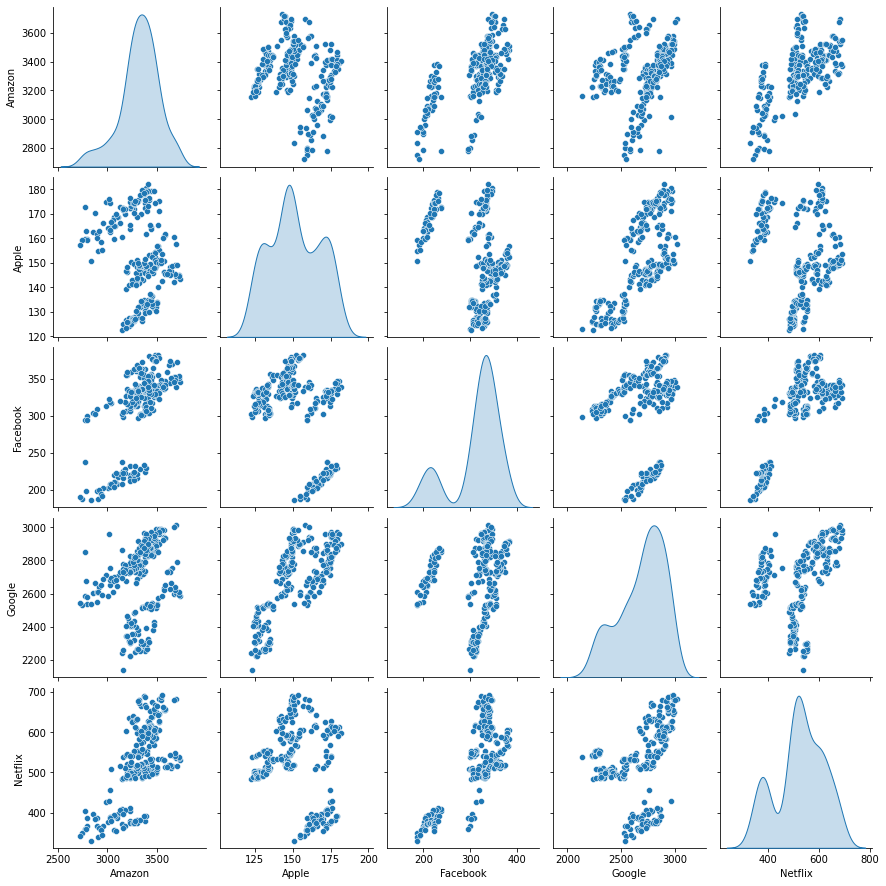

In [ ]:
faang_viz.pairplot()

## Análisis técnico
El análisis técnico consiste en observar las métricas para comprender el rendimiento de un activo.
### Activo único
Podemos utilizar la clase `StockAnalyzer` para calcular las métricas por nosotros:

In [ ]:
nflx_analyzer = stock_analysis.StockAnalyzer(nflx)

Una de estas medidas es la volatilidad anualizada:

In [ ]:
nflx_analyzer.annualized_volatility()

0.4064433889716779

### Grupos de Activos
Cuando se trabaja con grupos, se utiliza la clase `AssetGroupAnalyzer`:

In [ ]:
all_assets_analyzer = stock_analysis.AssetGroupAnalyzer(all_assets)

#### Coeficiente de variación
Podemos comprobar lo grande que es la desviación estándar en términos de la media del precio de las acciones como otra forma de ver la volatilidad. Esto muestra que el bitcoin y Netflix por su caida brusca de los ultimos dias son las más volátiles:

In [ ]:
all_assets_analyzer.analyze('cv')

{'Amazon': 0.05907502811529494,
 'Apple': 0.10853383221513742,
 'Bitcoin': 0.19378914853492196,
 'Facebook': 0.16168082588657903,
 'Google': 0.0778518823499135,
 'Netflix': 0.17554062829241376,
 'S&P 500': 0.04169666743811102}

#### Volatilidad anualizada

In [ ]:
all_assets_analyzer.analyze('annualized_volatility')

{'Amazon': 0.31693224292294575,
 'Apple': 0.24257822061995887,
 'Bitcoin': 0.544112787715287,
 'Facebook': 0.42026326860092283,
 'Google': 0.24964213463240026,
 'Netflix': 0.4064433889716779,
 'S&P 500': 0.1498825954307129}

#### Mercado alcista
Podemos comprobar si los activos están en un mercado alcista, lo que significa que su valor aumentó $\geq$ 20% en los últimos 2 meses:

In [ ]:
all_assets_analyzer.analyze('is_bull_market')

{'Amazon': False,
 'Apple': False,
 'Bitcoin': False,
 'Facebook': False,
 'Google': False,
 'Netflix': False,
 'S&P 500': False}

#### Mercado bajista
Podemos comprobar si los activos están en un mercado bajista, es decir, si su valor ha caído un 20% en los últimos dos meses:

In [ ]:
all_assets_analyzer.analyze('is_bear_market')

{'Amazon': False,
 'Apple': False,
 'Bitcoin': False,
 'Facebook': False,
 'Google': False,
 'Netflix': False,
 'S&P 500': False}

#### Beta
La beta nos dice cómo se correlaciona el rendimiento de un activo con un índice de mercado. Una beta de 1 con el S&P 500 significa que el activo se mueve con el S&P 500.

In [ ]:
all_assets_analyzer.analyze('beta', index=sp)

{'Amazon': 1.3087167142410636,
 'Apple': 1.26103274845879,
 'Bitcoin': 1.4678409889180413,
 'Facebook': 1.7951462993206202,
 'Google': 1.31225353855441,
 'Netflix': 1.2979965670993785,
 'S&P 500': 1.0}

#### Alfa
El alfa nos permite comparar la rentabilidad de un activo con un índice. Podemos comparar con el S&P 500 utilizando la tasa de rendimiento libre de riesgo. Puedes buscar las tasas [aquí](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/TextView.aspx?data=yield) o utilizar el método `StockReader.get_risk_free_rate_of_return()`. Esto muestra que el bitcoin tiene un rendimiento mucho más bajo que el S&P 500 (debido a la escala) y que Apple es el que más rinde entre las acciones FAANG:

In [ ]:
r_f = reader.get_risk_free_rate_of_return()
all_assets_analyzer.analyze('alpha', index=sp, r_f=r_f)

{'Amazon': -0.16681044534083866,
 'Apple': 0.24300553571107458,
 'Bitcoin': -0.4440883577328008,
 'Facebook': -0.44312380311521316,
 'Google': 0.10933757173013497,
 'Netflix': -0.4833960209894449,
 'S&P 500': 0.0}

#### Rendimientos acumulados
Los rendimientos acumulados nos muestran lo que habríamos ganado por una inversión en dólares en el periodo de tiempo 0. Esto se puede multiplicar por la inversión real para obtener la rentabilidad:

Text(0.5, 0.98, 'Rendimiento acumulado')

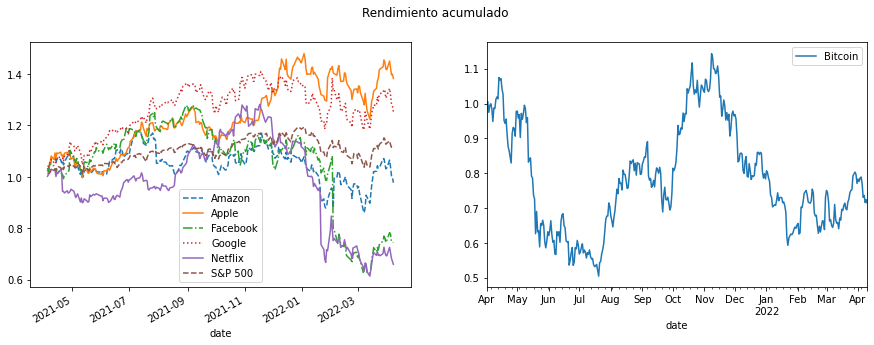

In [ ]:
from cycler import cycler

# para que esto sea un poco más fácil de ver en el texto en blanco y negro
bw_viz_cycler = (
    cycler(color=[plt.get_cmap('tab10')(x/10) for x in range(10)])
    + cycler(linestyle=['dashed', 'solid', 'dashdot', 'dotted', 'solid'] * 2)
)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].set_prop_cycle(bw_viz_cycler)
cumulative_returns = all_assets_analyzer.analyze('cumulative_returns')

for name, data in cumulative_returns.items():
    data.plot(
        ax=axes[1] if name == 'Bitcoin' else axes[0], 
        label=name,
        legend=True
    )
fig.suptitle('Rendimiento acumulado')

## Modelado
Para las tareas de modelado, podemos utilizar la clase `StockModeler`:

In [ ]:
from stock_analysis import StockModeler

### Descomposición de la serie temporal
Podemos descomponer la serie temporal de Netflix en su tendencia, su componente de estacionalidad y sus residuos:

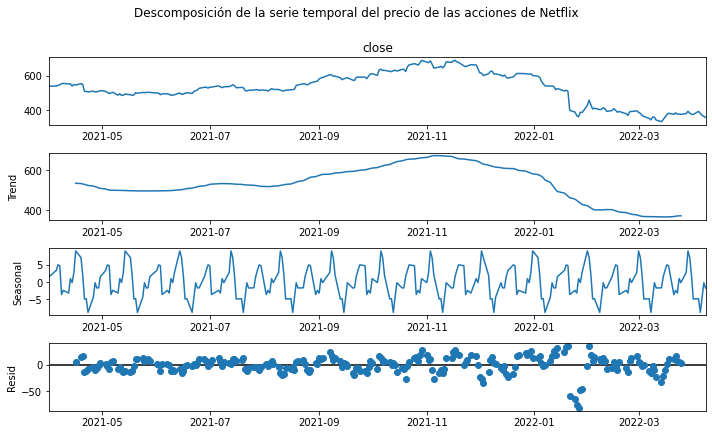

In [ ]:
decomposition = StockModeler.decompose(nflx, 20) # 20 period frequency
fig = decomposition.plot()
fig.suptitle('Descomposición de la serie temporal del precio de las acciones de Netflix', y=1)
fig.set_figheight(6)
fig.set_figwidth(10)
fig.tight_layout()

### ARIMA
Podemos utilizar ARIMA para modelar el rendimiento con términos autorregresivos (AR), diferencias o datos retardados (I) y media móvil (MA). El gráfico de autocorrelación puede ayudar a encontrar un buen punto de partida para ello:

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

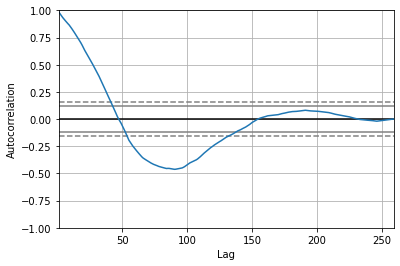

In [ ]:
# we can use autocorrelation plots to find a good starting point for ARIMA
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(nflx.close)

Los gráficos de retraso también pueden ser útiles:

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

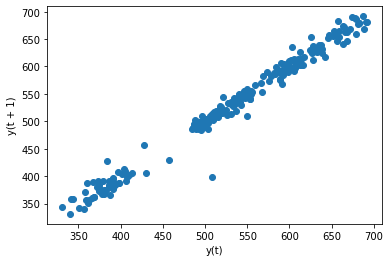

In [ ]:
from pandas.plotting import lag_plot
lag_plot(nflx.close)

ARIMA tarda mucho tiempo en entrenarse, así que empezaremos con un AR de 10:

In [ ]:
%%capture
# esto tarda mucho en ejecutarse, así que empezaremos con un AR más pequeño de 10
arima_model = StockModeler.arima(nflx, ar=10, i=1, ma=5)

El método `summary()` muestra estadísticas sobre el rendimiento del modelo:

In [ ]:
# AR = 10, I = 1, MA = 5
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  267
Model:                ARIMA(10, 1, 5)   Log Likelihood               -1029.636
Date:                Fri, 29 Apr 2022   AIC                           2091.272
Time:                        22:41:12   BIC                           2148.608
Sample:                    04-01-2021   HQIC                          2114.306
                         - 04-08-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4183      0.282     -1.482      0.138      -0.972       0.135
ar.L2          0.0985      0.189      0.522      0.602      -0.271       0.468
ar.L3         -0.0911      0.186     -0.490      0.6

Los residuos parecen tener una distribución normal (subtrazado de la derecha); sin embargo, su tamaño parece depender del tiempo (subtrazado de la izquierda), por lo que puede que no sea un buen modelo:

array([<AxesSubplot:title={'center':'Residuals'}, xlabel='Date', ylabel='Residual'>,
       <AxesSubplot:title={'center':'Residuals KDE'}, xlabel='Residual', ylabel='Density'>],
      dtype=object)

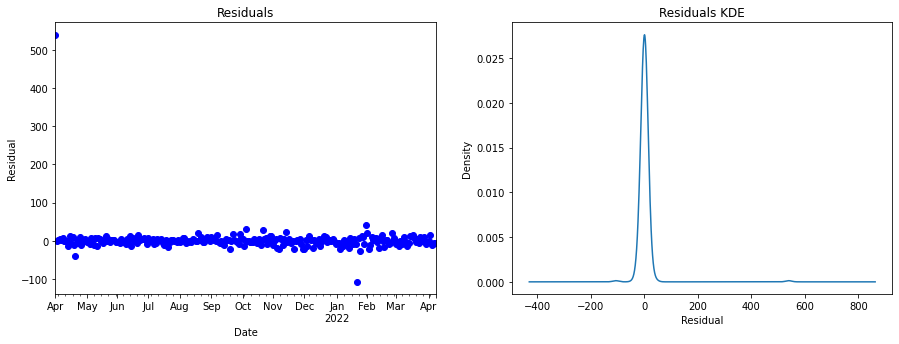

In [ ]:
StockModeler.plot_residuals(arima_model)

### Regresión lineal
Podemos construir una regresión lineal utilizando el último valor para determinar el siguiente:

In [ ]:
X, Y, lm = StockModeler.regression(nflx)
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:                  close   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          4.811e+05
Date:                Fri, 29 Apr 2022   Prob (F-statistic):                        0.00
Time:                        22:41:25   Log-Likelihood:                         -1014.6
No. Observations:                 258   AIC:                                      2031.
Df Residuals:                     257   BIC:                                      2035.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Una vez más, los residuos parecen depender del tiempo:

array([<AxesSubplot:title={'center':'Residuals'}, xlabel='Date', ylabel='Residual'>,
       <AxesSubplot:title={'center':'Residuals KDE'}, xlabel='Residual', ylabel='Density'>],
      dtype=object)

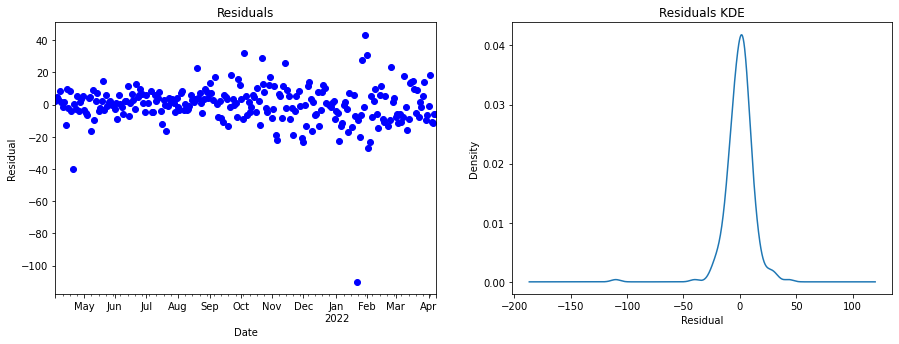

In [ ]:
StockModeler.plot_residuals(lm)

### Comparación de los modelos con la realidad
Veamos cómo se comparan estos modelos con lo que realmente ocurrió:

Text(0, 0.5, 'precio ($)')

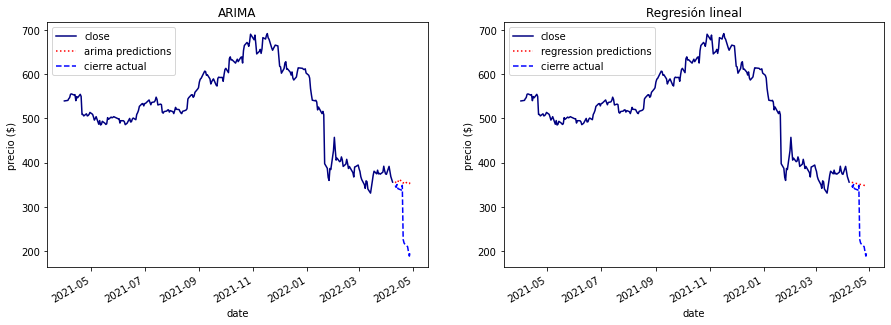

In [ ]:
import datetime as dt

start = dt.date(2022, 4, 11)
end = dt.date(2022, 4, 28)

jan = stock_analysis.StockReader(start, end).get_ticker_data('NFLX')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

arima_ax = StockModeler.arima_predictions(
    nflx, arima_model, start=start, end=end,
    ax=axes[0], title='ARIMA', color='navy'
)
jan.close.plot(ax=arima_ax, style='b--', label='cierre actual')
arima_ax.legend()
arima_ax.set_ylabel('precio ($)')

linear_reg = StockModeler.regression_predictions(
    nflx, lm, start=start, end=end,
    ax=axes[1], title='Regresión lineal', color='navy'
)
jan.close.plot(ax=linear_reg, style='b--', label='cierre actual')
linear_reg.legend()
linear_reg.set_ylabel('precio ($)')

### Paseos aleatorios
La predicción es difícil debido a la aleatoriedad. El precio de las acciones puede modelarse como un [paseo aleatorio](https://en.wikipedia.org/wiki/Random_walk). ¿Puedes encontrar los datos reales de las acciones? 

*Nota*: Para obtener resultados diferentes, pasa un número al argumento `seed`.

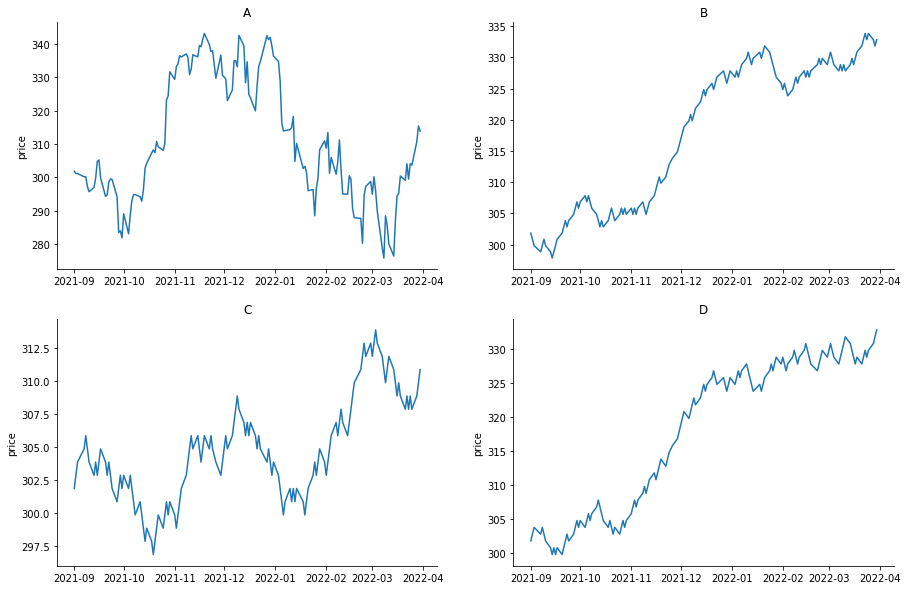

In [ ]:
msft = stock_analysis.StockReader('2021-09-01', '2022-03-30').get_ticker_data('MSFT')
real_stock, axes = finance_viz.random_walk_stock_comparison(msft, probs=[0.45, 0.55])
plt.show()

Was your guess correct?

In [ ]:
real_stock

'real stock is at location A'